In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

2025-08-18 11:00:27.920472: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755514828.296599      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755514828.402820      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = "/kaggle/input/data-256-256-new/data_256_256_new"

In [3]:
df = pd.read_excel(f"{base_dir}/labels.xlsx")

# full file paths
df["filepath"] = df["id"].apply(lambda x: os.path.join(base_dir, x))
print(df.head())

                id label                                           filepath
0  Red/Red (1).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
1  Red/Red (2).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
2  Red/Red (3).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
3  Red/Red (4).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...
4  Red/Red (5).jpg   Red  /kaggle/input/data-256-256-new/data_256_256_ne...


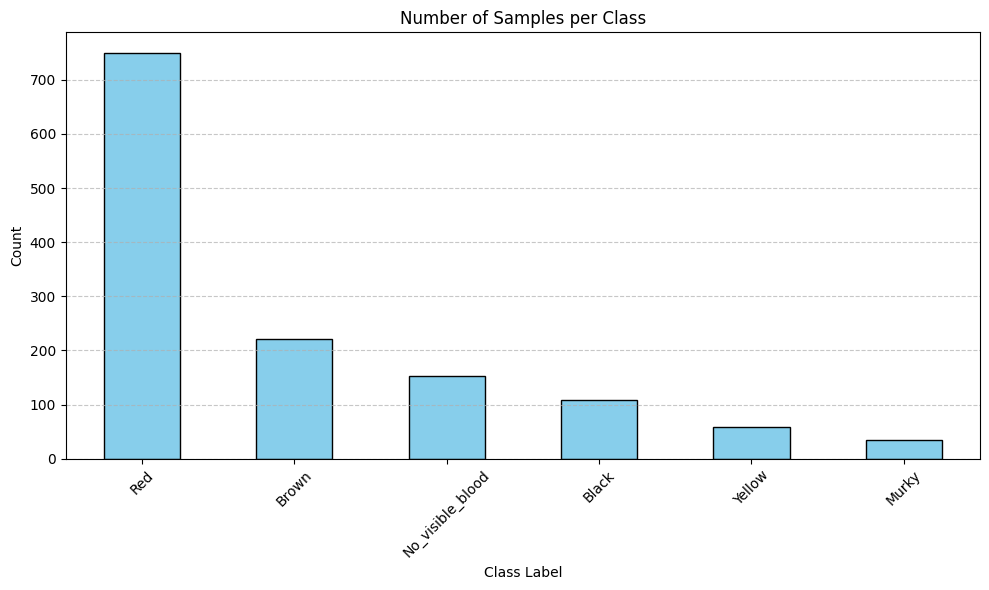

In [4]:
class_counts = df['label'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Samples per Class')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Pre-Processing

In [5]:
print("Loading images...")
images = []
labels = []
for i, row in df.iterrows():
    try:
        img = load_img(row["filepath"], target_size=(256, 256))
        img_array = img_to_array(img) / 255.0  # normalize
        images.append(img_array)
        labels.append(row["label"])
        
        if (i + 1) % 100 == 0:
            print(f"Loaded {i + 1} images.")
    except Exception as e:
        print(f"Error loading {row['filepath']}: {e}")

Loading images...
Loaded 100 images.
Loaded 200 images.
Loaded 300 images.
Loaded 400 images.
Loaded 500 images.
Loaded 600 images.
Loaded 700 images.
Loaded 800 images.
Loaded 900 images.
Loaded 1000 images.
Loaded 1100 images.
Loaded 1200 images.
Loaded 1300 images.


In [6]:
images = np.array(images)
labels = np.array(labels)
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: (1325, 256, 256, 3), Labels shape: (1325,)


In [7]:
# Encode labels
le = LabelEncoder()
labels_int = le.fit_transform(labels)
labels_onehot = to_categorical(labels_int)

print("Integer labels (first 5):", labels_int[:5])
print("One-hot labels (first 5):", labels_onehot[:5])
print("Classes:", le.classes_)

num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

Integer labels (first 5): [4 4 4 4 4]
One-hot labels (first 5): [[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]]
Classes: ['Black' 'Brown' 'Murky' 'No_visible_blood' 'Red' 'Yellow']
Number of classes: 6


## Split

In [8]:
# First split: 80% train+val, 20% test
X_temp, X_test, y_temp, y_test, labels_temp, labels_test = train_test_split(
    images, labels_onehot, labels_int, 
    test_size=0.2, random_state=42, stratify=labels_int
)

In [9]:
X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(
    X_temp, y_temp, labels_temp,
    test_size=0.25, random_state=42, stratify=labels_temp  
)

In [10]:
print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

Train set: (795, 256, 256, 3), (795, 6)
Validation set: (265, 256, 256, 3), (265, 6)
Test set: (265, 256, 256, 3), (265, 6)


## Model

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,267,398 (50.61 MB)

 Trainable params: 13,267,398 (50.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Set up callbacks
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    verbose=1,
    restore_best_weights=True
)

In [14]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[checkpoint, early_stopping],
    verbose=1
)

Epoch 1/30


I0000 00:00:1755514900.135153     104 service.cc:148] XLA service 0x7ac824006140 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755514900.136647     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755514900.136675     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755514900.587362     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


 3/25 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.4705 - loss: 2.2254

I0000 00:00:1755514908.161952     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.5134 - loss: 1.7318
Epoch 1: val_accuracy improved from -inf to 0.56604, saving model to best_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 457ms/step - accuracy: 0.5143 - loss: 1.7225 - val_accuracy: 0.5660 - val_loss: 1.2078
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5723 - loss: 1.2740
Epoch 2: val_accuracy improved from 0.56604 to 0.62642, saving model to best_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5721 - loss: 1.2713 - val_accuracy: 0.6264 - val_loss: 1.0395
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5647 - loss: 1.1319
Epoch 3: val_accuracy improved from 0.62642 to 0.64151, saving model to best_model.h5
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.5651 - loss: 1.1293 - val_accuracy: 0.6415 - val_loss: 0.9618
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5770 - loss: 1.1094
Epoch 4: val_accuracy did not improve from 0.64151
25/25 ━━━━━━

In [15]:
loss, accuracy = model.evaluate(X_train, y_train)
print(f"Train Accuracy: {accuracy*100:.2f}%")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - accuracy: 0.7504 - loss: 0.6120
Train Accuracy: 74.84%


In [16]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6693 - loss: 0.9369
Validation Accuracy: 69.43%


## Loss and Accuracy Matrices

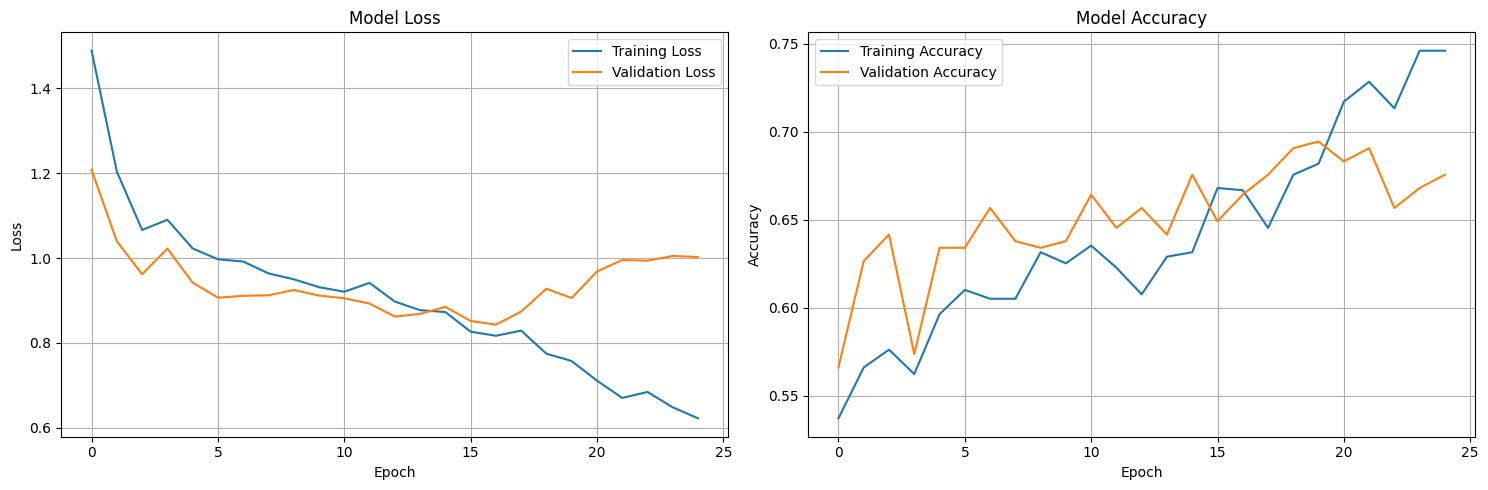

In [17]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Other Matrices

In [18]:
# Load the best model
best_model = tf.keras.models.load_model('best_model.h5')

In [19]:
# Make predictions on all sets
train_preds = np.argmax(best_model.predict(X_train), axis=1)
val_preds = np.argmax(best_model.predict(X_val), axis=1)
test_preds = np.argmax(best_model.predict(X_test), axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [20]:
# Convert one-hot labels back to integers for comparison
y_train_int = np.argmax(y_train, axis=1)
y_val_int = np.argmax(y_val, axis=1)
y_test_int = np.argmax(y_test, axis=1)

In [21]:
# Calculate accuracies
train_accuracy = np.mean(y_train_int == train_preds)
val_accuracy = np.mean(y_val_int == val_preds)
test_accuracy = np.mean(y_test_int == test_preds)

In [22]:
print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 0.7484
Validation Accuracy: 0.6943
Test Accuracy: 0.6415


In [24]:
# Detailed classification report for test set
print("\n=== Train Set Classification Report ===")
print(classification_report(y_train_int, train_preds, target_names=le.classes_))


=== Train Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.95      0.58      0.72        65
           Brown       0.46      0.78      0.58       134
           Murky       0.00      0.00      0.00        20
No_visible_blood       0.62      0.49      0.55        92
             Red       0.89      0.90      0.90       450
          Yellow       0.00      0.00      0.00        34

        accuracy                           0.75       795
       macro avg       0.49      0.46      0.46       795
    weighted avg       0.73      0.75      0.73       795



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# Detailed classification report for test set
print("\n=== Validation Set Classification Report ===")
print(classification_report(y_val_int, val_preds, target_names=le.classes_))


=== Validation Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.71      0.23      0.34        22
           Brown       0.42      0.61      0.50        44
           Murky       0.00      0.00      0.00         7
No_visible_blood       0.53      0.53      0.53        30
             Red       0.83      0.91      0.87       150
          Yellow       0.00      0.00      0.00        12

        accuracy                           0.69       265
       macro avg       0.42      0.38      0.37       265
    weighted avg       0.66      0.69      0.66       265



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [26]:
# Detailed classification report for test set
print("\n=== Test Set Classification Report ===")
print(classification_report(y_test_int, test_preds, target_names=le.classes_))


=== Test Set Classification Report ===
                  precision    recall  f1-score   support

           Black       0.62      0.23      0.33        22
           Brown       0.34      0.64      0.44        44
           Murky       0.00      0.00      0.00         7
No_visible_blood       0.47      0.27      0.34        30
             Red       0.82      0.86      0.84       150
          Yellow       0.00      0.00      0.00        12

        accuracy                           0.64       265
       macro avg       0.38      0.33      0.33       265
    weighted avg       0.62      0.64      0.61       265



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


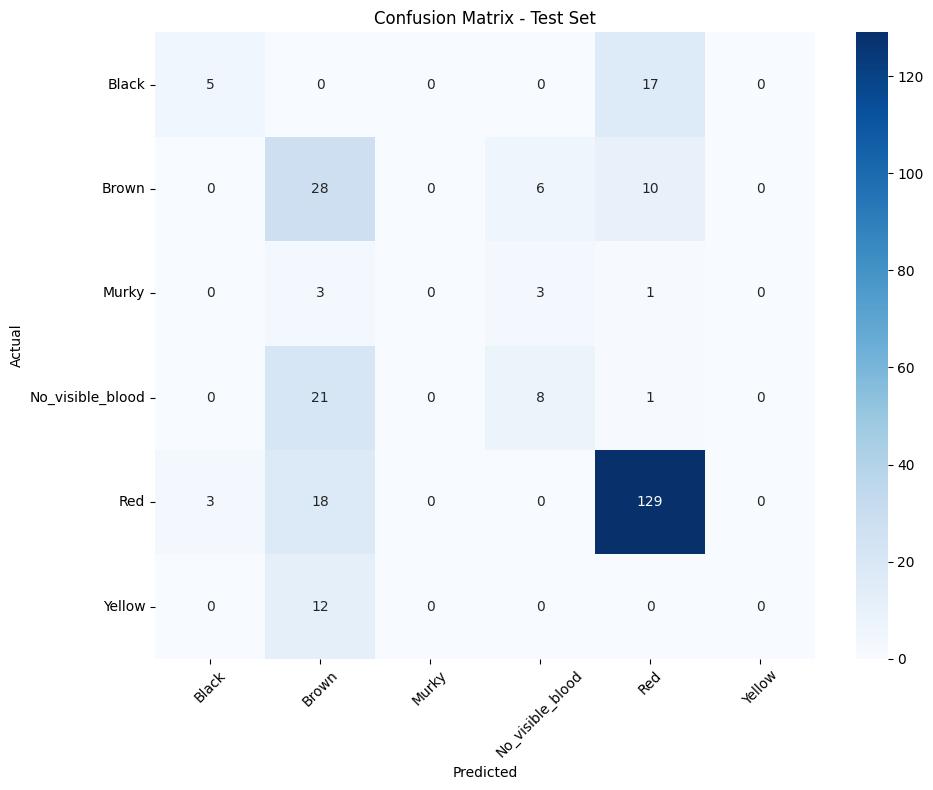

In [27]:
# Confusion Matrix for test set
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_int, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()